### Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "Ответ:".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.


In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


Мы будем работать с датасетом "bikes_rent.csv", в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции pandas.read_csv в переменную df. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:


In [25]:
# Ваш код
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('../data/14 bikes_rent.csv', sep=',')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):

season: 1 - весна, 2 - лето, 3 - осень, 4 - зима

yr: 0 - 2011, 1 - 2012

mnth: от 1 до 12

holiday: 0 - нет праздника, 1 - есть праздник

weekday: от 0 до 6

workingday: 0 - нерабочий день, 1 - рабочий день

weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)

temp: температура в Цельсиях

atemp: температура по ощущениям в Цельсиях

hum: влажность

windspeed(mph): скорость ветра в милях в час

windspeed(ms): скорость ветра в метрах в секунду

cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных


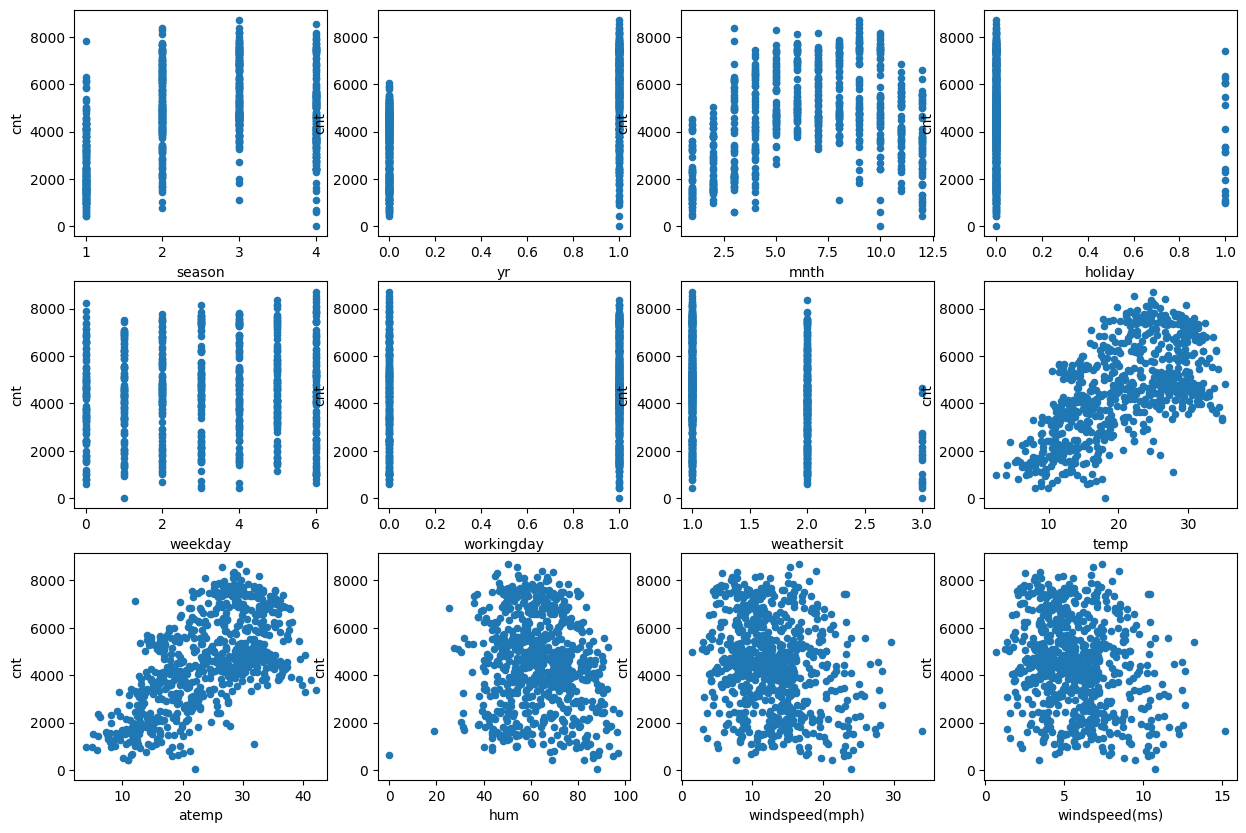

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

### Блок 1. Ответьте на вопросы :

1.	Каков характер зависимости числа прокатов от месяца? ответ: квадратичная


2.	Укажите один или два признака, от которых число прокатов скорее всего зависит линейно ответ: temp, atemp




Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма

In [27]:
# Код 1.1 
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
corr = df.iloc[:, :-1].corrwith(df['cnt'])
corr

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.
По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.


In [28]:
# Код 1.2 
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), win dspeed(ms) и cnt
# с помощью метода corr:
corr = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
corr.style.background_gradient(cmap='coolwarm')

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


#На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

#Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [29]:
# Код 1.3 
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.



In [30]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [31]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [32]:
df_norm = df_shuffled.copy()
for i in df_norm.columns[:-1]:
    df_norm[i] = df_norm[i] / max(df_norm[i])

df_norm.mean()

season               0.624145
yr                   0.500684
mnth                 0.543320
holiday              0.028728
weekday              0.499544
workingday           0.683995
weathersit           0.465116
temp                 0.574914
atemp                0.564105
hum                  0.645649
windspeed(mph)       0.375370
windspeed(ms)        0.375370
cnt               4504.348837
dtype: float64

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [34]:
# Код 2.1 
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенн ой в язык python
# Названия признаков хранятся в переменной df.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

for i, j in zip(df.columns, model_LR.coef_):
    print(i, j)

season 516.7541960286173
yr 982.5592477234221
mnth -113.33385855027939
holiday -61.9023820579169
weekday 102.89766660440141
workingday 20.86176155903898
weathersit -338.2204416195024
temp -611.5080004544558
atemp 1593.4629563430371
hum -189.78578242031116
windspeed(mph) 12743518124188.299
windspeed(ms) -12743518124384.496


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.


С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации α. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.



In [35]:
from sklearn.linear_model import Lasso, Ridge

In [53]:
# Код 2.2 
# Обучите линейную модель с L1-регуляризацией
model_Lasso = Lasso()
model_Lasso.fit(X_train, y_train)
for i, j in zip(df.columns, model_Lasso.coef_):
    print(i, j)

season 508.67999591810525
yr 979.1290842829484
mnth -103.1723521998373
holiday -63.37415312590541
weekday 100.60945680355664
workingday 20.292871229429146
weathersit -345.381841565332
temp -269.8063986903718
atemp 1249.172008306838
hum -184.6656819870977
windspeed(mph) -201.96223624659925
windspeed(ms) -7.576528831807668e-08


In [54]:
# Код 2.3 
# Обучите линейную модель с L2-регуляризацией
model_Ridge = Ridge()
model_Ridge.fit(X_train, y_train)
for i, j in zip(df.columns, model_Ridge.coef_):
    print(i, j)

season 511.7088071040324
yr 978.5488691725761
mnth -105.8089812810674
holiday -64.52545493648975
weekday 100.81902330501443
workingday 21.44680275306397
weathersit -346.65245687374863
temp -171.3628046804285
atemp 1148.3655478704002
hum -183.91814967650797
windspeed(mph) -102.39098755132807
windspeed(ms) -102.39098759597172


#### Блок 2. 

Поясните, каким образом введение регуляризации решает проблему с весами и  мультиколлинеарностью.

Ваш ответ 




#### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации α (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).


In [38]:
# Код 3.1 
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))  # матрица весов размера (число ре грессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i, alpha in enumerate(alphas):
    model_Lasso = Lasso(alpha=alpha)
    model_Lasso.fit(X_train, y_train)
    coefs_lasso[i] = model_Lasso.coef_
    model_Ridge = Ridge(alpha=alpha)
    model_Ridge.fit(X_train, y_train)
    coefs_ridge[i] = model_Ridge.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

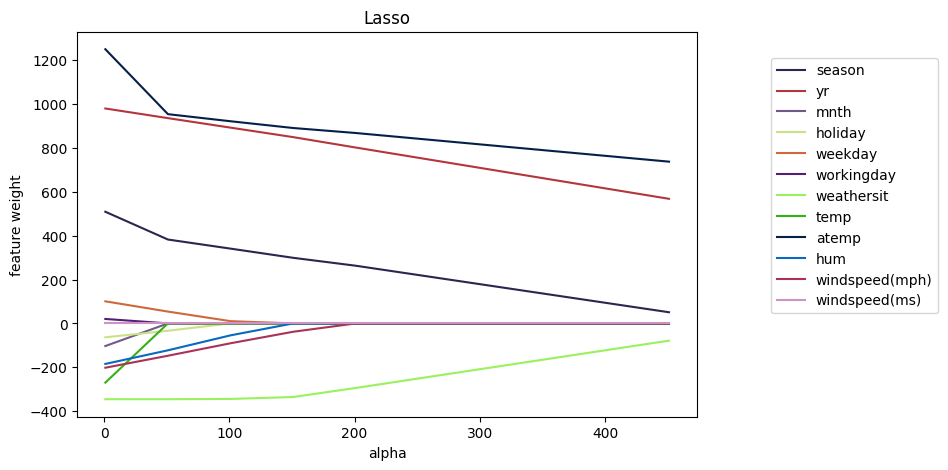

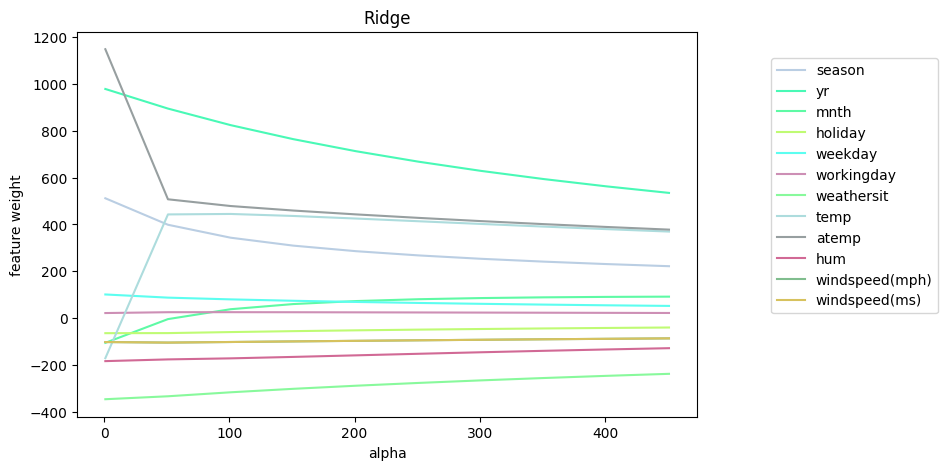

In [39]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")


Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

##### Блок 3. Ответьте на вопросы 

1.	Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же                              alpha?
Ответ: Lasso
2.	Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
Ответ: веса занулятся.
3.	Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении      alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
Ответ: Lasso: да, Ridge: нет.
4.	Какой из регуляризаторов подойдет для отбора неинформативных признаков? Ответ: : Lasso





###### Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную mse_path_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс- валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha_ будет храниться выбранное значение параметра регуляризации, а в coef_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.



In [40]:
from sklearn.linear_model import LassoCV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Выбранное альфа: 3


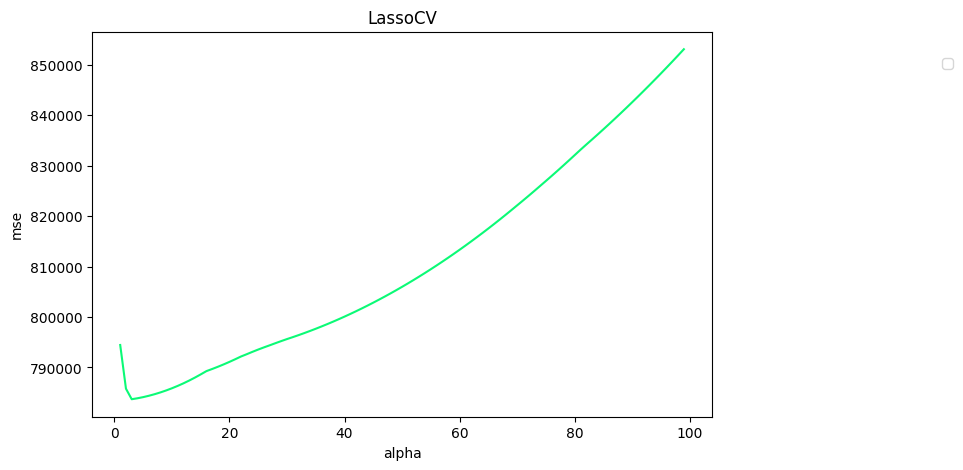

In [50]:
# Код 3.2 
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha.
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 1)
lassocv = LassoCV(alphas=alphas)
lassocv.fit(X, y)

plt.figure(figsize=(8, 5))

plt.plot(lassocv.alphas_, np.mean(lassocv.mse_path_, axis=1), color=np.random.rand(3))


plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title("LassoCV")

mse_alpha = lassocv.alpha_
print(f'Выбранное альфа: {mse_alpha}')

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали                                   alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [51]:
# Код 3.3 
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

for i, item in enumerate(np.min(lassocv.mse_path_, axis=0)):
    i_min = lassocv.mse_path_[:, i].argmin(axis=0)
    print(f'Альфа = {lassocv.alphas_[i_min]} mse = {round(item, 2)}')

Альфа = 9 mse = 850527.48
Альфа = 1 mse = 793023.36
Альфа = 3 mse = 735466.24
Альфа = 1 mse = 823368.85
Альфа = 1 mse = 714094.73


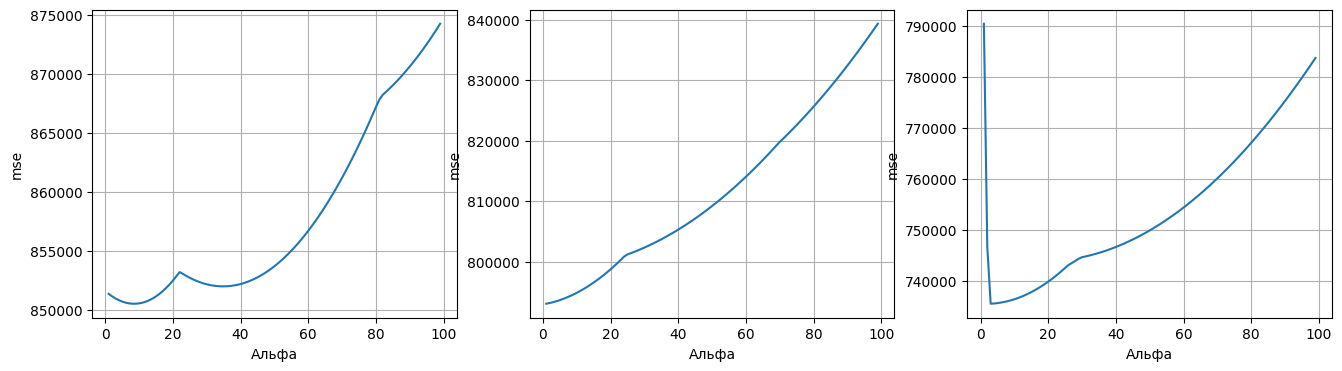

In [43]:
plt.figure(figsize=(16, 4))
for index in range(3):
    plt.subplot(1, 3, index + 1)
    plt.plot(lassocv.alphas_, lassocv.mse_path_[:, index])
    plt.xlabel('Альфа')
    plt.ylabel('mse')
    plt.grid()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки.
При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.



In [44]:
for i, j in zip(df.columns, lassocv.coef_):
    print(i, j)

season 548.9526359824251
yr 1017.7021441652352
mnth -117.25422962954151
holiday -85.00945284488708
weekday 135.4102486982526
workingday 53.750179268483464
weathersit -331.6460842050311
temp 374.12971907080254
atemp 578.4374753699045
hum -142.48006220279868
windspeed(mph) -194.99327160852232
windspeed(ms) -2.752275603350218e-08


##### Блок 4. Ответьте на вопросы:

1.	В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?
Ответ: season=548, yr=1017, temp=374, atemp=578
2.	Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
Ответ: weathersit=-331, hum=-142, windspeed(mph)=-194
3.	Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
Ответ: windspeed(ms)=-2e-8


###### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.
